# Comparison of gold and silver prices

## Setup

In [1]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Get gold and silver dfs and set date as index
df_au = pd.read_csv("../data/AU.csv", index_col="date", parse_dates=True)
df_ag = pd.read_csv("../data/AG.csv", index_col="date", parse_dates=True)

In [3]:
# Set charts theme
sns.set_theme(style="darkgrid", rc={"grid.alpha": 0.33})
plt.style.use("dark_background")

# Save chart as png function
def save_chart_as_png(filename: str) -> None:
    plt.savefig(
        f"../images/{filename}.png",
        format="png",
        dpi=300,
        orientation="landscape",
        bbox_inches="tight",
    )

## Preparing data into a combined df

In [4]:
# Get 1-year volatility of gold and silver with the exponentially weighted moving average method
for df, name in [(df_au, "au"), (df_ag, "ag")]:
    df["log_returns"] = np.log(df["price"] / df["price"].shift(1))
    df[f"{name}_volatility"] = df["log_returns"].ewm(span=252).std()
    df.loc[:df.index[251], f"{name}_volatility"] = np.nan
    df.drop(columns=["log_returns"], inplace=True)

In [5]:
# Rename dfs cols
df_au.rename(columns={"price": "au_price"}, inplace=True)
df_ag.rename(columns={"price": "ag_price"}, inplace=True)

In [6]:
# Combine them in one df (avoiding any NaN values)
df_combined = df_au.join(df_ag, how="inner")

## Comparison

### Prices

In [7]:
# Add decade col
df_combined["decade"] = df_combined.index.year // 10 * 10

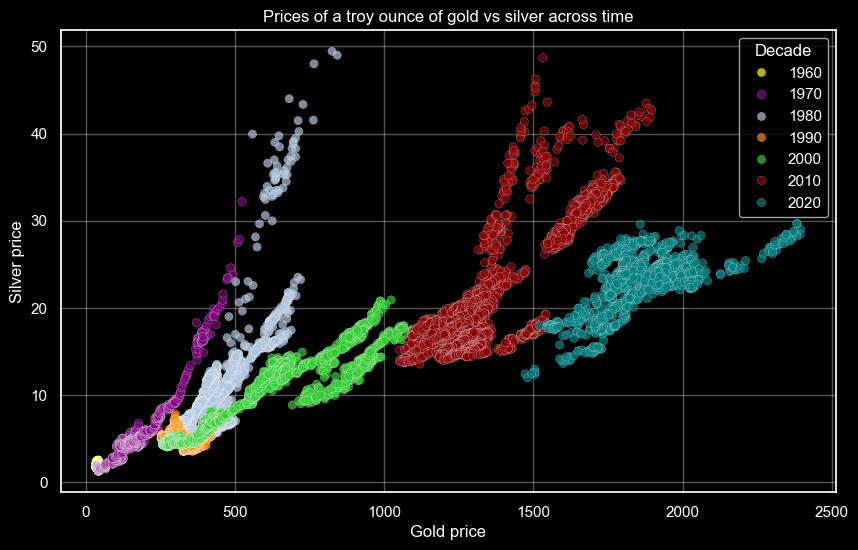

In [8]:
plt.figure(figsize=(10, 6))
custom_palette = ["yellow", "purple", "lightsteelblue", "darkorange", "limegreen", "darkred", "teal"]

sns.scatterplot(data=df_combined, x="au_price", y="ag_price", hue="decade", palette=custom_palette, alpha=0.7, linewidth=0.2)

plt.title("Prices of a troy ounce of gold vs silver across time")
plt.xlabel("Gold price")
plt.ylabel("Silver price")
plt.legend(title="Decade")

save_chart_as_png("5_AU_AG_comparison_price_scatter")

**Key takeaways:**
- This scatter plot clearly shows the robust correlation (0.9) between gold and silver prices.
- In the 1970s, 1980s, and 2000s, there were periods when silver prices rose more sharply than gold prices.
- Overall, gold prices seem to have risen more than silver, though this varies by decade.

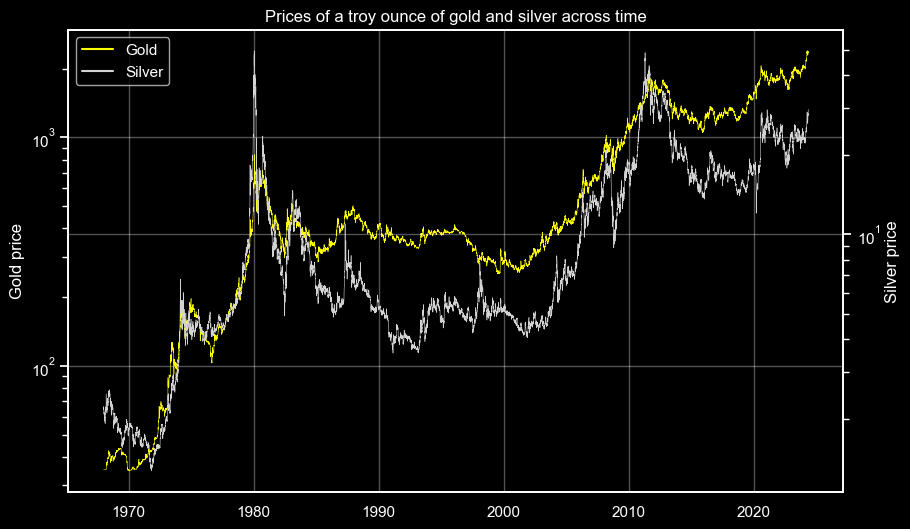

In [9]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

au_color = "yellow"
ag_color = "lightgrey"

sns.lineplot(data=df_combined, x=df_combined.index, y="au_price", ax=ax1, color=au_color, linewidth=0.4)
sns.lineplot(data=df_combined, x=df_combined.index, y="ag_price", ax=ax2, color=ag_color, linewidth=0.4)

# Compress the y axis to see early price fluctuations
ax1.set_yscale("log")
ax2.set_yscale("log")

plt.title("Prices of a troy ounce of gold and silver across time")
ax1.set_xlabel("")
ax1.set_ylabel("Gold price")
ax2.set_ylabel("Silver price")

# Manually create legend handles with a larger linewidth just to be able to see it
legend_handles = [Line2D([0], [0], color=au_color, lw=1.5, label="Gold"),
                  Line2D([0], [0], color=ag_color, lw=1.5, label="Silver")]
ax1.legend(handles=legend_handles)

save_chart_as_png("5_AU_AG_comparison_price")

**Key takeaways:**
- During the 1970s, price fluctuations of gold and silver were close, but silver began losing momentum in the mid-1980s.
- In the 1990s, price fluctuations diverged, with silver showing some recovery in the late 2000s and early 2010s before falling again since the 2010s.
- To have a better notion, we need to analyze the gold-to-silver ratio.

#### Price ratio

In [10]:
# Get gold to silver price ratio col and its 1-year moving average
df_combined["price_ratio"] = df_combined["au_price"] / df_combined["ag_price"]
df_combined["price_ratio_1y_ma"] = df_combined["price_ratio"].rolling(window=252).mean()

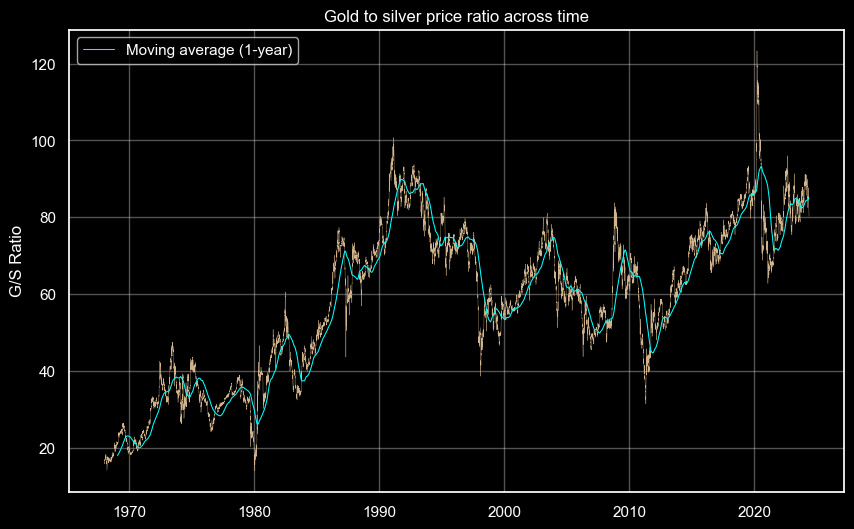

In [11]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_combined, x=df_combined.index, y="price_ratio", color="tan", linewidth=0.25)
sns.lineplot(data=df_combined, x=df_combined.index, y="price_ratio_1y_ma", label="Moving average (1-year)", color="aqua", linewidth=0.75)

plt.title("Gold to silver price ratio across time")
plt.xlabel("")
plt.ylabel("G/S Ratio")

save_chart_as_png("5_AU_AG_comparison_price_ratio")

In [12]:
# Get average ratio per decade
df_combined_dec = df_combined.groupby("decade")
df_combined_dec = df_combined_dec["price_ratio"].mean().round(2).reset_index()
df_combined_dec.columns = ["decade", "average_price_ratio"]
df_combined_dec.set_index("decade").T

decade,1960,1970,1980,1990,2000,2010,2020
average_price_ratio,20.46,31.68,52.74,73.76,61.59,67.62,82.34


**Key takeaways:**
- The ratio was at its lowest before the mid-1980s.
- Throughout the 1980s, silver lost ground to gold, with the ratio peaking in the early 1990s.
- During this decade, silver partially recovered but then stabilized.
- In the 2010s, the ratio increased again.
- The current decade has the highest average ratio at 82.3, compared to 20.5 in the 1960s.

### Price change year-over-year

In [13]:
# Get YoY returns
# Get yearly prices df with first and last prices
df_combined_yearly = df_combined.groupby(df_combined.index.year).agg(
    au_first_price=pd.NamedAgg(column="au_price", aggfunc="first"),
    au_last_price=pd.NamedAgg(column="au_price", aggfunc="last"),
    ag_first_price=pd.NamedAgg(column="ag_price", aggfunc="first"),
    ag_last_price=pd.NamedAgg(column="ag_price", aggfunc="last")
)
# Get YoY return
df_combined_yearly["au_price_change"] = (df_combined_yearly["au_last_price"] - df_combined_yearly["au_first_price"]) / df_combined_yearly["au_first_price"]
df_combined_yearly["ag_price_change"] = (df_combined_yearly["ag_last_price"] - df_combined_yearly["ag_first_price"]) / df_combined_yearly["ag_first_price"]

In [14]:
# Get year col for id_vars (it must be a col and not index)
df_combined_yearly["year"] = df_combined_yearly.index
# Reshape the df to a long format (with metal price changes cols as rows) to make it suited for a bar chart
df_long = df_combined_yearly.melt(id_vars="year", value_vars=["au_price_change", "ag_price_change"], var_name="metal", value_name="price_change")
df_long["metal"] = df_long["metal"].map({"au_price_change": "Gold", "ag_price_change": "Silver"})
df_long.set_index("year", inplace=True)

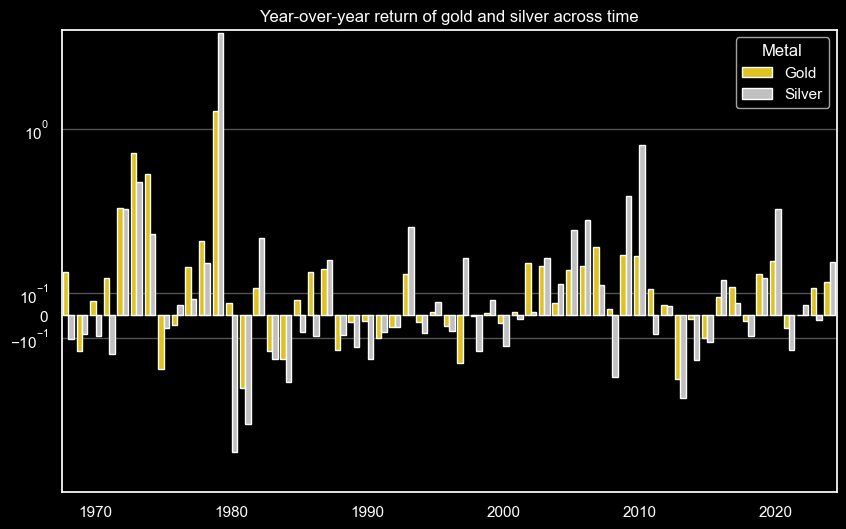

In [15]:
plt.figure(figsize=(10, 6))

ax = sns.barplot(data=df_long, x="year", y="price_change", hue="metal", palette={"Gold": "gold", "Silver": "silver"})

# Compress the y axis to see smaller bars
plt.yscale("symlog", linthresh=0.75)

plt.title("Year-over-year return of gold and silver across time")
plt.xlabel("")
plt.ylabel("")
plt.legend(title="Metal")

# Show only the beginning of the decade on the x-axis
ax = plt.gca()
for index, label in enumerate(ax.get_xticklabels()):
    if index % 10 - 2 != 0:
        label.set_visible(False)

save_chart_as_png("5_AU_AG_comparison_YoY_return")

**Since the 1980s, the absolute return on silver has generally been higher than gold, likely due to greater volatility. Comparing the difference of the return between bars will provide more insights.**

#### Price change year-over-year difference

In [16]:
# Get gold price change YoY advantage over silver's
df_combined_yearly["au_price_change_adv"] = df_combined_yearly["au_price_change"] - df_combined_yearly["ag_price_change"]
# Get the metal which has better performance
df_combined_yearly["best_metal"] = df_combined_yearly["au_price_change_adv"].apply(lambda x: "Gold" if x > 0 else "Silver")
# Make advantage values absolute and as percentage
df_combined_yearly["au_price_change_adv_pct"] = df_combined_yearly["au_price_change_adv"].abs() * 100

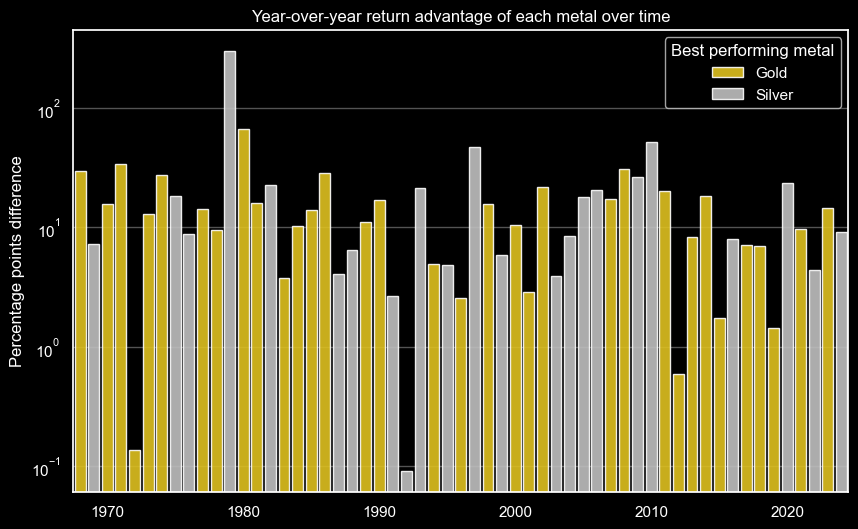

In [17]:
plt.figure(figsize=(10, 6))

sns.barplot(data=df_combined_yearly, x=df_combined_yearly.index, y="au_price_change_adv_pct", hue="best_metal", palette={"Gold": "gold", "Silver": "silver"}, alpha=0.9)

# Compress the y axis to see smaller bars
plt.yscale("log")
           
plt.title("Year-over-year return advantage of each metal over time")
plt.xlabel("")
plt.ylabel("Percentage points difference")
plt.legend(title="Best performing metal")

# Show only beginning of decade
ax = plt.gca()
for index, label in enumerate(ax.get_xticklabels()):
    if index % 10 - 2 != 0:
        label.set_visible(False)

save_chart_as_png("5_AU_AG_comparison_YoY_return_diff")

In [18]:
# Number of bars of gold
df_combined_yearly[df_combined_yearly["best_metal"] == "Gold"]["best_metal"].count()

34

In [19]:
# Number of bars of silver
df_combined_yearly[df_combined_yearly["best_metal"] == "Silver"]["best_metal"].count()

23

In [20]:
# Average difference
(df_combined_yearly["au_price_change"].mean() - df_combined_yearly["ag_price_change"].mean()).round(4)

-0.0205

In [21]:
# Average difference excluding 1979
(df_combined_yearly.loc[df_combined_yearly.index != 1979, "au_price_change"].mean() - df_combined_yearly.loc[df_combined_yearly.index != 1979, "ag_price_change"].mean()).round(4)

0.0324

In [22]:
# Median difference
(df_combined_yearly["au_price_change"].median() - df_combined_yearly["ag_price_change"].median()).round(4)

0.0702

In [23]:
# Standard deviation difference
(df_combined_yearly["au_price_change"].std() - df_combined_yearly["ag_price_change"].std()).round(4)

-0.3653

In [24]:
# Cumulative product difference
((1 + df_combined_yearly["au_price_change"]).cumprod().iloc[-1].round(4) - 1) - ((1 + df_combined_yearly["ag_price_change"]).cumprod().iloc[-1].round(4) - 1)

46.9001

**Key takeaways:**
- Gold has outperformed silver in 34 years, whereas silver outperformed gold in 23 years.
- This year, silver is outperforming gold by approximately 10 percentage points.
- On average, silver's year-over-year return is about 2 percentage points higher than gold's.
- However, excluding the anomalous year of 1979 for both metals, gold takes the lead, boasting a return approximately 3.2 percentage points higher than silver.
- Moreover, gold shines with a median YoY return about 7 percentage points greater than silver's.
- Gold also outperforms silver by approximately 470 percentage points in cumulative YoY returns.
- Given this, gold generally performs better than silver on a YoY basis.

### Yearly volatility

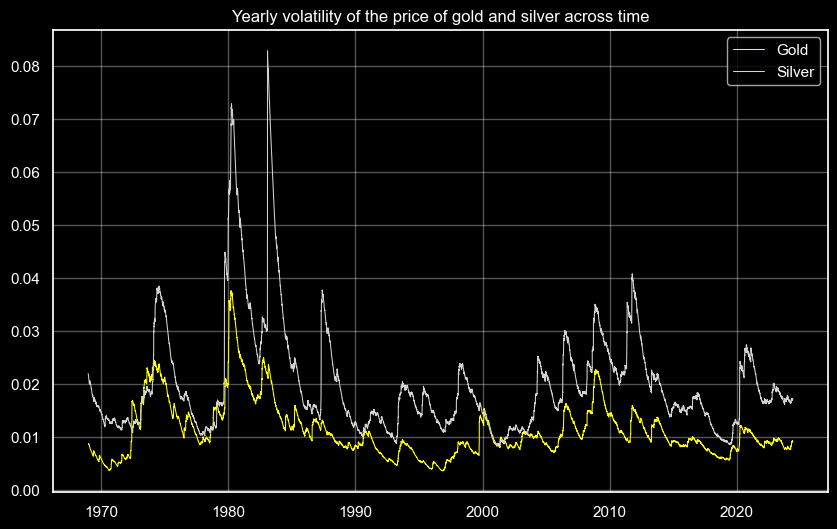

In [25]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_combined, x=df_combined.index, y="au_volatility", label="Gold", color="yellow", linewidth=0.75)
sns.lineplot(data=df_combined, x=df_combined.index, y="ag_volatility", label="Silver", color="lightgrey", linewidth=0.75)

plt.title("Yearly volatility of the price of gold and silver across time")
plt.xlabel("")
plt.ylabel("")

save_chart_as_png("5_AU_AG_comparison_Y_vlt")

In [26]:
# Get gold avg volatility
df_combined["au_volatility"].mean().round(4)

0.0111

In [27]:
# Get silver avg volatility
df_combined["ag_volatility"].mean().round(4)

0.0201

**Key takeaways:**
- The high correlation (0.78) between the metals' volatilities is evident, though not as strong as the correlation between their prices.
- Silver has shown significantly higher volatility, particularly since the 1980s.
- The average volatility of silver is almost double that of gold.

#### Yearly volatility ratio

In [28]:
# Get gold to silver yearly volatility ratio col
df_combined["volatility_ratio"] = df_combined["au_volatility"] / df_combined["ag_volatility"]

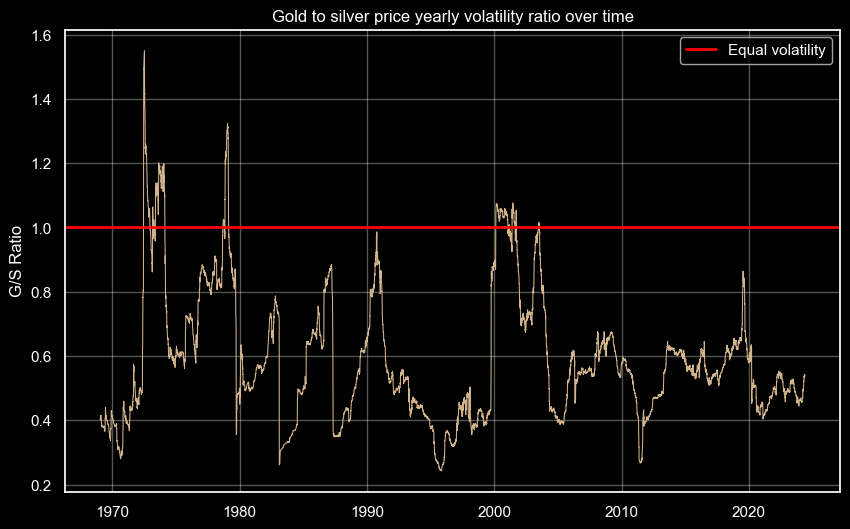

In [29]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_combined, x=df_combined.index, y="volatility_ratio", color="tan", linewidth=0.75)
plt.axhline(y=1, label="Equal volatility", color="red", linewidth=2)

plt.title("Gold to silver price yearly volatility ratio over time")
plt.xlabel("")
plt.ylabel("G/S Ratio")
plt.legend()

save_chart_as_png("5_AU_AG_comparison_Y_vlt_ratio")

In [30]:
# Get the percentage of time in which ratio was at least 1
(df_combined[df_combined["volatility_ratio"] >= 1]["volatility_ratio"].count() / df_combined["volatility_ratio"].count() * 100).round(2)

5.53

**Periods where gold was more volatile than silver are rare, occurring less than 6% of the time, mainly in the 1970s and also on early 2000s.**